In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import Generate_technical_indicators, StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import numpy as np
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, returns_from_cumulative

from technical_indicators.technical_indicators import full_rmr_moving_average, olmar_moving_average

tf.__version__
print("Imports Complete")







Imports Complete


In [2]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

models = []
model_names = []
framework_lst = ['TD3']
window_length_lst = [3, 7, 11, 14]
maximum_window = max(window_length_lst)
predictor_type_lst = ['lstm']
use_batch_norm = True
log_return = True
load_technical_indicators = True

In [3]:
# Stock History
dataset_name = 'nyse_n'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: nyse_n
Assets: ['ahp', 'alcoa', 'amer_brands', 'coke', 'comm_metals', 'dow_chem', 'Dupont', 'ford', 'ge', 'gm', 'hp', 'ibm', 'ingersoll', 'jnj', 'kimb-clark', 'kin_ark', 'Kodak', 'merck', 'mmm', 'morris', 'p_and_g', 'schlum', 'sher_will']
Stock History Shape: (23, 6430, 2)
Full Stock History Date Range: 02/01/1985 -> 30/06/2010


In [4]:
full_length = len(date_list)
train_test_ratio = 6/7
train_start_date = date_list[maximum_window]
train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
test_start_date = date_list[(int)(full_length * train_test_ratio)]
test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 22/01/1985 -> 02/11/2006 (5496 Steps)
Testing Date Range: 03/11/2006 -> 29/06/2010 (917 Steps)


In [5]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    technical_indicator_history = []

    # Close Price DataFrame for on-line Portfolio Selection
    temp_close_df = create_close_dataframe(history, assets, date_list)
    temp_close_df = convert_prices(temp_close_df, 'raw', True)    
    if debug:
        print('temp_close_df.shape: {}'.format(temp_close_df.shape))

    rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
    for i in range(len(assets)):
        # Create List
        ti = []
        #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
        ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

        # Turn to Array
        ti = np.vstack(ti)

        ti_reshaped = []
        for j in range(temp_close_df.shape[0]):
            ti_reshaped.append(ti[:, j])   

        technical_indicator_history.append(ti_reshaped)

    technical_indicator_history = np.array(technical_indicator_history)    
    if debug:
        print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    
    ti_dict[window_length] = technical_indicator_history
    
    return technical_indicator_history

In [6]:
if load_technical_indicators:
    # Load Technical Indicators dataset
    ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
else:
    ti_dict = {}
    for window_length in window_length_lst:
        technical_indicator_history = GenerateTechnicalIndicators(window_length)
        ti_dict[window_length] = technical_indicator_history
    np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [7]:
# WITHOUT TECHNICAL INDICATORS
# instantiate environment
for framework in framework_lst:
    for window_length in window_length_lst:
        for predictor_type in predictor_type_lst:
            name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
            model_names.append(name)
            tf.reset_default_graph()
            sess = tf.Session()
            tflearn.config.init_training_mode()
            action_dim = [nb_classes]
            state_dim = [nb_classes, window_length]
                
            variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                                use_batch_norm, False)

            with tf.variable_scope(variable_scope):
                
                if(framework == 'DDPG'):
                    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                       predictor_type, use_batch_norm)
                    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, False)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, False)

                    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                                      log_return=log_return, config_file='config/stock.json', 
                                      model_save_path=model_save_path, summary_path=summary_path)
                    ddpg_model.initialize(load_weights=True, verbose=True)
                    models.append(ddpg_model)
                    
                elif(framework == 'TD3'):
                    actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                          predictor_type, use_batch_norm)
                    critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                               inp_actions=actor.scaled_out)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, False)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, False)

                    td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                                    log_return=log_return, config_file='config/stock.json', 
                                    model_save_path=model_save_path, summary_path=summary_path)
                    td3_model.initialize(load_weights=True, verbose=True)
                    models.append(td3_model)


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_3/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_3_batch_norm/LSTM/nyse_n_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_3_batch_norm/LSTM/nyse_n_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_3_batch_norm/LSTM/nyse_n_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_7/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_7_batch_norm/LSTM/nyse_n_TD3_lstm_window_7_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm/LSTM/nyse_n_TD3_lstm_window_7_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_7_batch_norm/LSTM/nyse_n_TD3_lstm_window_7_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm/LSTM/nyse_n_TD3_lstm_window_7_batch_norm/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_7_batch_norm/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm/FullyConnected/W
Loading nyse_n_TD3_lstm_window_7_batch_norm/FullyConnected/b:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm/FullyConnected/b
Loading nyse_n_TD3_lstm_window_7_batch_norm/BatchNormalizatio

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_11/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_11_batch_norm/LSTM/nyse_n_TD3_lstm_window_11_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm/LSTM/nyse_n_TD3_lstm_window_11_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_11_batch_norm/LSTM/nyse_n_TD3_lstm_window_11_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm/LSTM/nyse_n_TD3_lstm_window_11_batch_norm/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_11_batch_norm/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm/FullyConnected/W
Loading nyse_n_TD3_lstm_window_11_batch_norm/FullyConnected/b:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm/FullyConnected/b
Loading nyse_n_TD3_lstm_window_11_batch_norm/Bat

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_14/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_14_batch_norm/LSTM/nyse_n_TD3_lstm_window_14_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm/LSTM/nyse_n_TD3_lstm_window_14_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_14_batch_norm/LSTM/nyse_n_TD3_lstm_window_14_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm/LSTM/nyse_n_TD3_lstm_window_14_batch_norm/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_14_batch_norm/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm/FullyConnected/W
Loading nyse_n_TD3_lstm_window_14_batch_norm/FullyConnected/b:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm/FullyConnected/b
Loading nyse_n_TD3_lstm_window_14_batch_norm/Bat

In [8]:
# With Technical Indicators
# instantiate environment
for framework in framework_lst:
    for window_length in window_length_lst:
        for predictor_type in predictor_type_lst:
            name = '{}_{}_window_{}_predictor_{}_{}'.format(dataset_name, framework, window_length, predictor_type, "rmr-pred")
            model_names.append(name)
            tf.reset_default_graph()
            sess = tf.Session()
            tflearn.config.init_training_mode()
            action_dim = [nb_classes]
            technical_indicator_history = ti_dict[window_length]
            state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]

            variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                                use_batch_norm, True)

            with tf.variable_scope(variable_scope):

                if(framework == 'DDPG'):
                    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                       predictor_type, use_batch_norm)
                    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, True)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, True)

                    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                                      log_return=log_return, config_file='config/stock.json', 
                                      model_save_path=model_save_path, summary_path=summary_path)
                    ddpg_model.initialize(load_weights=True, verbose=True)
                    models.append(ddpg_model)

                elif(framework == 'TD3'):
                    actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                          predictor_type, use_batch_norm)
                    critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                               inp_actions=actor.scaled_out)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, True)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, True)

                    td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                                    log_return=log_return, config_file='config/stock.json', 
                                    model_save_path=model_save_path, summary_path=summary_path)
                    td3_model.initialize(load_weights=True, verbose=True)
                    models.append(td3_model)

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_3/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_3_batch_norm_technic

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_7/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technic

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_11/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_n

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_14/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_n

In [9]:
model_names

['nyse_n_TD3_window_3_predictor_lstm',
 'nyse_n_TD3_window_7_predictor_lstm',
 'nyse_n_TD3_window_11_predictor_lstm',
 'nyse_n_TD3_window_14_predictor_lstm',
 'nyse_n_TD3_window_3_predictor_lstm_rmr-pred',
 'nyse_n_TD3_window_7_predictor_lstm_rmr-pred',
 'nyse_n_TD3_window_11_predictor_lstm_rmr-pred',
 'nyse_n_TD3_window_14_predictor_lstm_rmr-pred']

#### IN SAMPLE

Model: nyse_n_TD3_window_3_predictor_lstm


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_3_predictor_lstm_rmr-pred


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_7_predictor_lstm


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_7_predictor_lstm_rmr-pred


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_11_predictor_lstm


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_11_predictor_lstm_rmr-pred


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_14_predictor_lstm


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: nyse_n_TD3_window_14_predictor_lstm_rmr-pred


/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

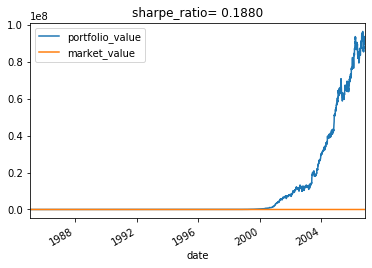

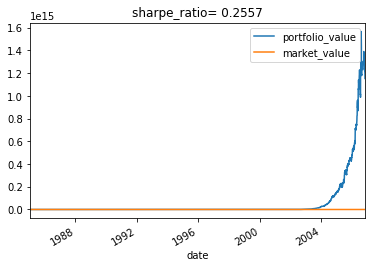

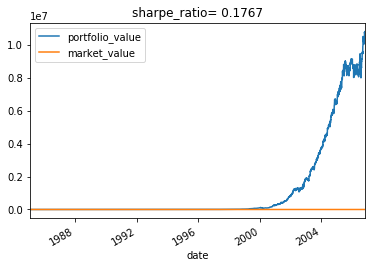

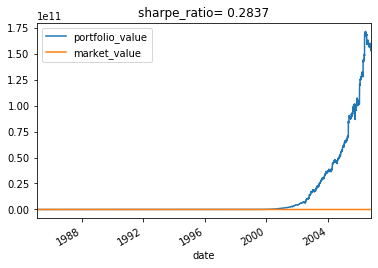

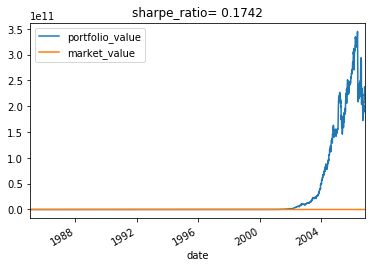

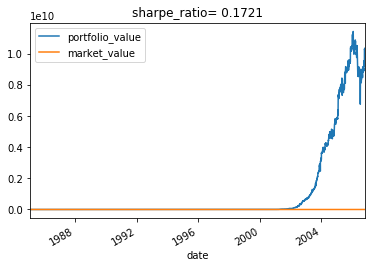

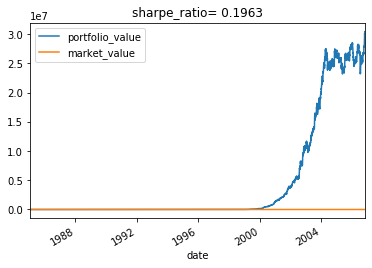

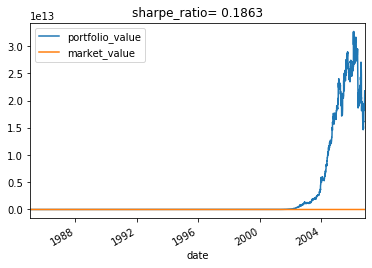

In [10]:
# Compiled Results
full_model_names = []
full_models = []
full_observations_list = []
full_info_list = []
full_action_list = []
full_df_performance = []
in_portfolio_values_list = [] 

for window_length in window_length_lst:
    model_names_subset = []
    models_subset = []
    for i in range(len(model_names)):
        if 'window_{}'.format(window_length) in model_names[i]:
            if 'rmr-pred' in model_names[i]:
                ti_model_name = model_names[i]
                ti_model = models[i]
            else:
                model_name = model_names[i]
                model = models[i]
            
    # no technical indicators ------------------------
    print("Model: {}".format(model_name))
    env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length)

    _, observations, info_list, actions, _, _, portfolio_values, _ = test_model(env, model)
    
    # Add to results
    full_model_names.append(model_name)
    full_models.append(model)    
    full_observations_list.append(observations)    
    full_info_list.append(info_list)    
    full_action_list.append(actions)  
    in_portfolio_values_list.append(portfolio_values)
        
    # technical indicators ---------------------------
    print("Model: {}".format(ti_model_name))
    env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    
    _, observations, info_list, actions, _, _, portfolio_values, _ = test_model(env, ti_model)
    
    # Add to results
    full_model_names.append(ti_model_name)
    full_models.append(ti_model)    
    full_observations_list.append(observations)    
    full_info_list.append(info_list)    
    full_action_list.append(actions)  
    in_portfolio_values_list.append(portfolio_values)

In [11]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
in_observations_list, in_olps_portfolio_values_list, in_weights_list, in_dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6430
=========BCRP=========
252.0
len(weights_array): 5497
=========OLMAR=========
len(weights_array): 5497
=========PAMR=========
len(weights_array): 5497
=========RMR=========
len(weights_array): 5497
=========WMAMR=========
len(weights_array): 5497
=========EG=========
len(weights_array): 5497
=========ONS=========
len(weights_array): 5497
=========UP=========
len(weights_array): 5497


In [24]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for i in range(len(full_model_names)):
    df = results_table_row(df, full_model_names[i],
                           returns_from_cumulative(in_portfolio_values_list[i]),
                           in_portfolio_values_list[i])

for i in range(len(olps_model_names)):
    df = results_table_row(df, olps_model_names[i],
                           returns_from_cumulative(in_olps_portfolio_values_list[i]),
                           in_olps_portfolio_values_list[i])

# Market
#df = results_table_row(df, 'market_value',
#                           returns_from_cumulative(extract_from_infos(info_list, 'market_value')),
#                           extract_from_infos(info_list, 'market_value'))
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm,0.3514,18.8051,28.2412,35.2000,9.124934e+07
1,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.6655,25.5671,47.0909,33.8889,1.153280e+15
2,nyse_n_TD3_window_7_predictor_lstm,0.3105,17.6658,23.8539,44.8653,1.071927e+07
3,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.4841,28.3501,48.9964,27.0313,1.567683e+11
4,nyse_n_TD3_window_11_predictor_lstm,0.5188,17.4155,27.4417,50.0274,2.140313e+11
5,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,0.4546,17.2074,26.1733,40.8567,1.033885e+10
6,nyse_n_TD3_window_14_predictor_lstm,0.3275,19.6288,33.1083,28.1589,2.996663e+07
7,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.6095,18.6155,32.4207,55.2065,1.953684e+13
8,CRP,0.0618,6.2972,8.0582,31.5102,2.305000e+01
9,BCRP,0.0857,6.4699,9.0536,44.4480,6.877000e+01


#### OUT OF SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-pac

<Figure size 432x288 with 0 Axes>

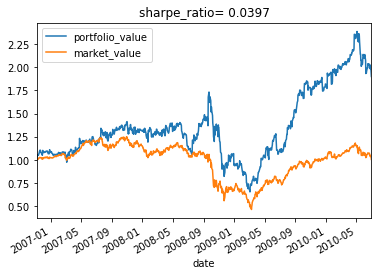

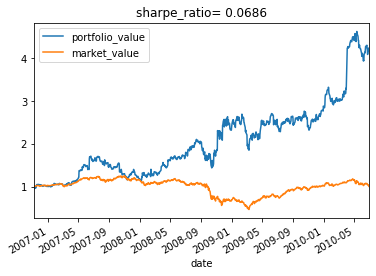

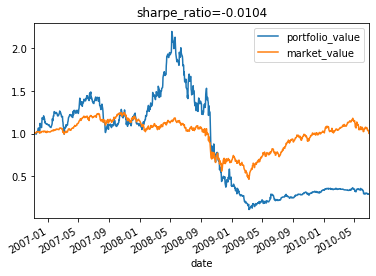

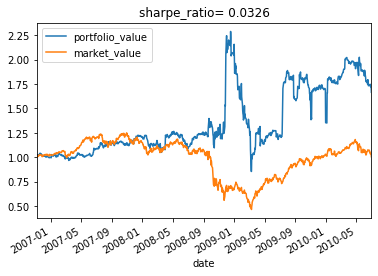

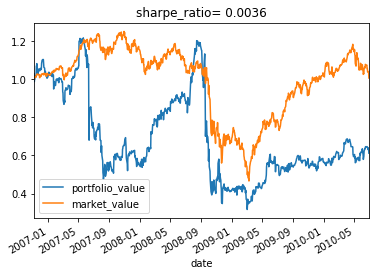

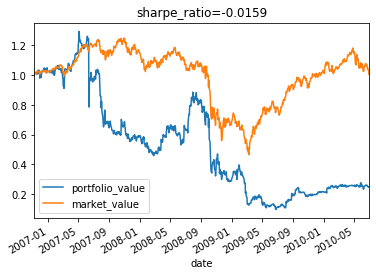

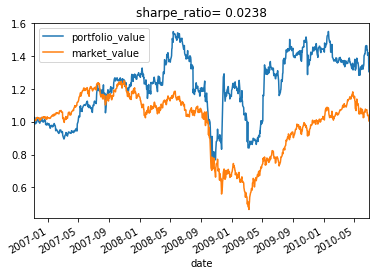

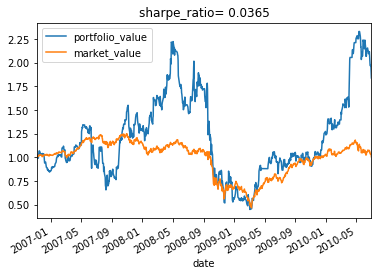

In [12]:
# Compiled Results
full_model_names = []
full_models = []
full_observations_list = []
full_info_list = []
full_action_list = []
full_df_performance = []
portfolio_values_list = [] 

for window_length in window_length_lst:
    model_names_subset = []
    models_subset = []
    for i in range(len(model_names)):
        if 'window_{}'.format(window_length) in model_names[i]:
            if 'rmr-pred' in model_names[i]:
                ti_model_name = model_names[i]
                ti_model = models[i]
            else:
                model_name = model_names[i]
                model = models[i]
                
    # no technical indicators ------------------------
    env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length)

    dates, observations, info_list, actions, _, _, portfolio_values, market_values = test_model(env, model)
    
    # Add to results
    full_model_names.append(model_name)
    full_models.append(model)    
    full_observations_list.append(observations)    
    full_info_list.append(info_list)    
    full_action_list.append(actions)  
    portfolio_values_list.append(portfolio_values)
        
    # technical indicators ---------------------------
    env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    
    dates, observations, info_list, actions, _, _, portfolio_values, market_values = test_model(env, ti_model)
    
    # Add to results
    full_model_names.append(ti_model_name)
    full_models.append(ti_model)    
    full_observations_list.append(observations)    
    full_info_list.append(info_list)    
    full_action_list.append(actions)  
    portfolio_values_list.append(portfolio_values)

#### Plot

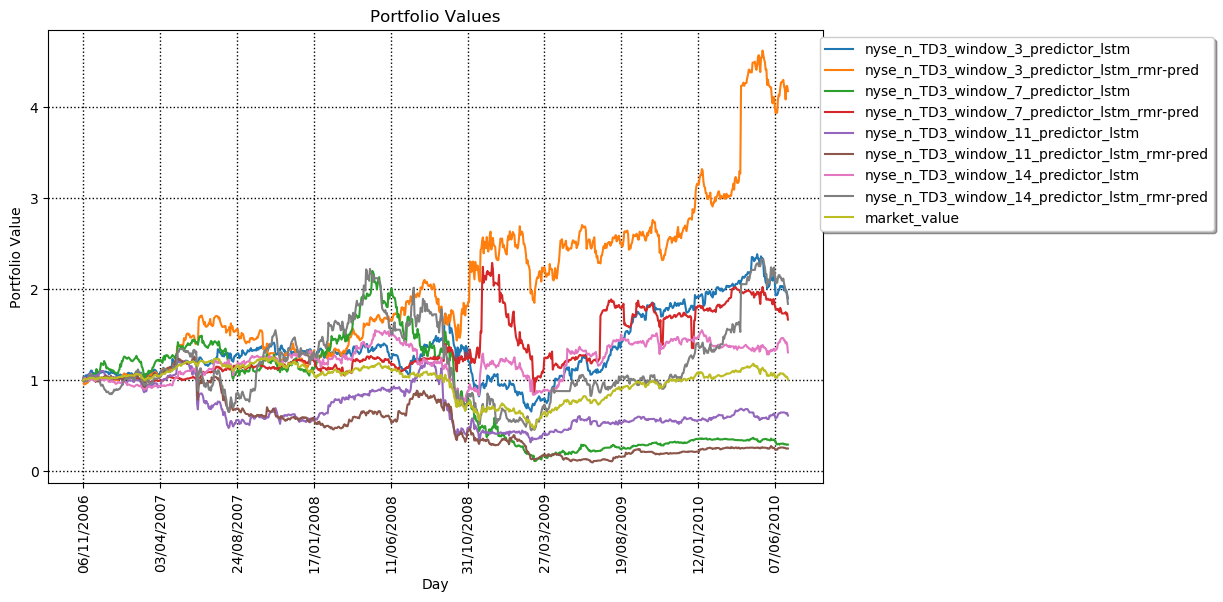

In [13]:
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i])
df['market_value'] = market_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

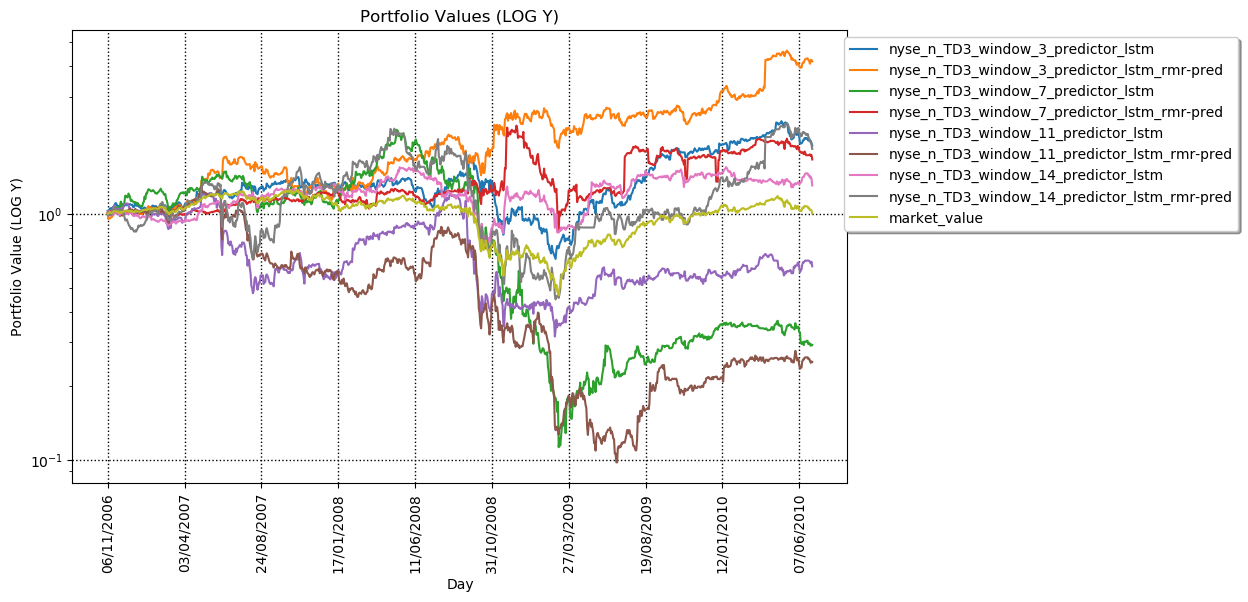

In [14]:
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i])
df['market_value'] = market_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [15]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for i in range(len(full_model_names)):
    df = results_table_row(df, full_model_names[i],
                           returns_from_cumulative(portfolio_values_list[i]),
                           portfolio_values_list[i])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(market_values),
                           market_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm,0.1031,3.9864,5.9757,62.1236,1.899
1,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.1950,6.8767,11.1415,33.1255,4.174
2,nyse_n_TD3_window_7_predictor_lstm,-0.0435,-1.0358,-1.2823,94.8897,0.293
3,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.1032,3.2326,4.4480,62.6059,1.665
4,nyse_n_TD3_window_11_predictor_lstm,0.0098,0.2726,0.3240,73.9230,0.612
5,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,-0.0662,-1.6105,-2.0313,92.4604,0.250
6,nyse_n_TD3_window_14_predictor_lstm,0.0591,2.3820,3.2996,52.1218,1.305
7,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
8,market_value,0.0184,0.9736,1.2451,62.6889,1.005


#### Compare with online-portfolio selection

In [16]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6430
=========BCRP=========
252.0
len(weights_array): 918
=========OLMAR=========
len(weights_array): 918
=========PAMR=========
len(weights_array): 918
=========RMR=========
len(weights_array): 918
=========WMAMR=========
len(weights_array): 918
=========EG=========
len(weights_array): 918
=========ONS=========
len(weights_array): 918
=========UP=========
len(weights_array): 918


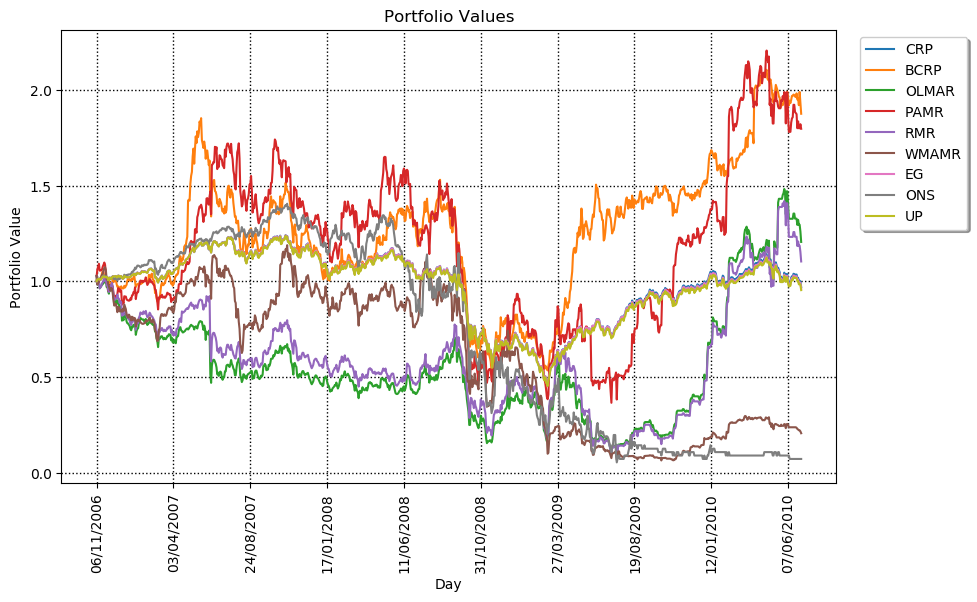

In [17]:
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i])
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

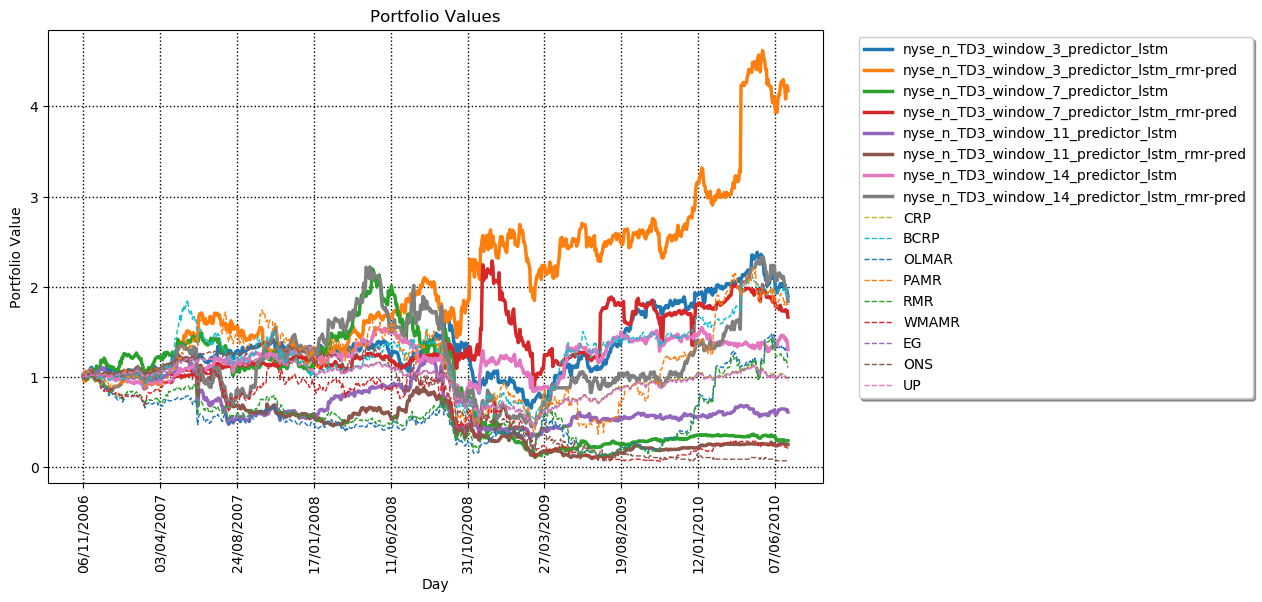

In [18]:
log_y = False

df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i],
         linewidth=2.5)

for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], linewidth=1, linestyle='dashed')
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [19]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for i in range(len(full_model_names)):
    df = results_table_row(df, full_model_names[i],
                           returns_from_cumulative(portfolio_values_list[i]),
                           portfolio_values_list[i])

for i in range(len(olps_model_names)):
    df = results_table_row(df, olps_model_names[i],
                           returns_from_cumulative(olps_portfolio_values_list[i]),
                           olps_portfolio_values_list[i])

df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm,0.1031,3.9864,5.9757,62.1236,1.899
1,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.1950,6.8767,11.1415,33.1255,4.174
2,nyse_n_TD3_window_7_predictor_lstm,-0.0435,-1.0358,-1.2823,94.8897,0.293
3,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.1032,3.2326,4.4480,62.6059,1.665
4,nyse_n_TD3_window_11_predictor_lstm,0.0098,0.2726,0.3240,73.9230,0.612
5,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,-0.0662,-1.6105,-2.0313,92.4604,0.250
6,nyse_n_TD3_window_14_predictor_lstm,0.0591,2.3820,3.2996,52.1218,1.305
7,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
8,CRP,0.0145,0.7684,0.9817,63.2787,0.970
9,BCRP,0.1139,3.7366,5.8033,73.2078,1.876


--------------
### Compare two models

KeyError: 'SP500_TD3_window_11_predictor_lstm'

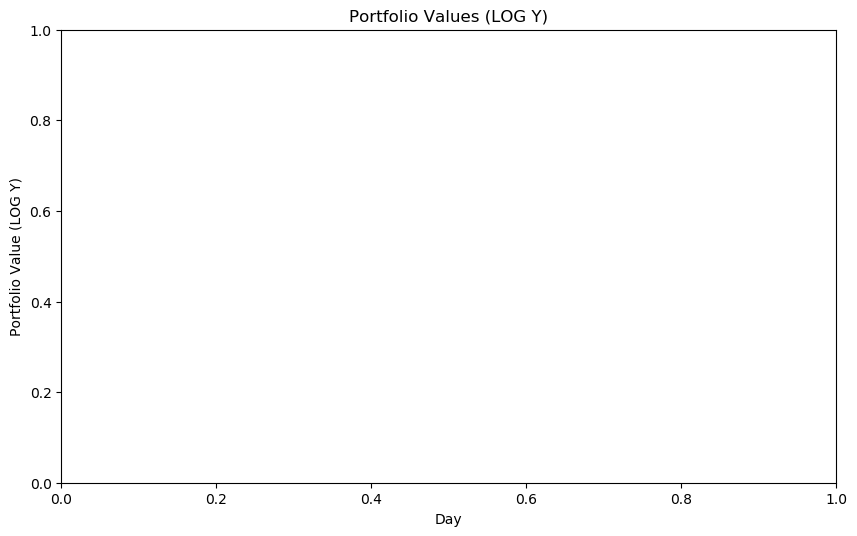

In [20]:
compare_model_names = ["SP500_TD3_window_11_predictor_lstm", "SP500_TD3_window_3_predictor_lstm_rmr-pred"]

log_y = True

df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
for name in compare_model_names:
    plt.plot(df[name], label=name,
         linewidth=2.5)

for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], linewidth=1, linestyle='dashed')
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

----------------
### Best Model vs. Benchmarks
1. Rolling Average Daily Yield (%) 	
2. Rolling Sharpe Ratio (%)
3. Rolling Sortino Ratio (%) 
4. Rolling Maximum Drawdown (%)

In [ ]:
eps = 1e-8
def sharpe(returns, rfr=0):
    """ Given a set of returns, calculates naive (rfr=0) sharpe """
    # Clean list
    returns = [x for x in returns if str(x) != 'nan']
    if len(returns) < 10:
        return float('NaN')
    
    if isinstance(returns, list): 
        returns = np.array(returns)
    result = (np.mean(returns - rfr + eps)) / np.std(returns - rfr + eps)
    return round(result*100, 4)

def sortino(returns, rfr=0):
    """ Given a set of returns, calculates naive (rfr=0) sortino """
    # Clean list
    returns = [x for x in returns if str(x) != 'nan']
    if len(returns) < 10:
        return float('NaN')
    
    if isinstance(returns, list): 
        returns = np.array(returns)
    result = (np.mean(returns - rfr + eps)) / np.std([r for r in (returns - rfr + eps) if r < 0])
    return round(result*100, 4)

def max_drawdown(portfolio_value):
    """ Max drawdown. See https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp """
    # Clean list
    portfolio_value = [x for x in portfolio_value if str(x) != 'nan']
    
    mdd = 0
    peak = 0
    for i in list(range(len(portfolio_value))): 
        # Check if possible peak
        if(portfolio_value[i] > peak):
            # Max drawdown assuming this is the peak
            peak = portfolio_value[i]
            trough = min(portfolio_value[i:])
            if(peak > trough):
                d = abs((trough - peak) / peak)
                if(d > mdd):
                    mdd = d
    return round(mdd*100, 4)

In [ ]:
full_model_names

In [ ]:
model_name = full_model_names[0]
model_portfolio_values = portfolio_values_list[full_model_names.index(model_name)]
rolling_window = 100

### Rolling Average Daily Yield

In [ ]:
roll_ady_df = pd.DataFrame()
roll_ady_df["Date"] = dates
roll_ady_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Average Daily Yield (%) (Window = {})'.format(rolling_window))
plt.ylabel('Average Daily Yield (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_ady_df[olps_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_ady_df[full_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.30, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_ady_df.drop('returns', axis=1, inplace=True)

### Rolling Sharpe Ratio

In [ ]:
roll_sha_df = pd.DataFrame()
roll_sha_df["Date"] = dates
roll_sha_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sharpe Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sharpe Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sha_df[olps_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sha_df[full_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.30, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sha_df.drop('returns', axis=1, inplace=True)

### Rolling Sortino Ratio

In [ ]:
roll_sor_df = pd.DataFrame()
roll_sor_df["Date"] = dates
roll_sor_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sortino Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sortino Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sor_df[olps_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sor_df[full_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop Column
roll_sor_df.drop('returns', axis=1, inplace=True)

### Rolling Maximum Drawdown

In [ ]:
roll_mdd_df = pd.DataFrame()
roll_mdd_df["Date"] = dates
roll_mdd_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Maximum Drawdown (%) (Window = {})'.format(rolling_window))
plt.ylabel('Maximum Drawdown (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_mdd_df['portfolio'] =  olps_portfolio_values_list[i]
    roll_mdd_df[olps_model_names[i]] = roll_mdd_df['portfolio'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_mdd_df['portfolio'] =  portfolio_values_list[i]
    roll_mdd_df[full_model_names[i]] = roll_mdd_df['portfolio'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop Column
roll_mdd_df.drop('portfolio', axis=1, inplace=True)

##### Statistical summary via T-test

In [ ]:
from scipy.stats import ttest_ind_from_stats

In [ ]:
# All OLPS vs TD3-14-lstm-rmr_pred
n = len(roll_ady_df)
our_model = 'nyse_n_TD3_window_14_predictor_lstm_rmr-pred'
print("{} vs... t-tests".format(our_model))

In [ ]:
# Average Daily Yield (%)
mean = roll_ady_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_ady_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_ady_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

ady_tstat_list = ['ADY_tstat']
ady_pvalue_list = ['ADY_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    ady_tstat_list.append(tstat)
    ady_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

for model in full_model_names:
    stat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[model]['mean'], _results_df[model]['std'], n)
    ady_tstat_list.append(tstat)
    ady_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
# Sharpe Ratio (%)
mean = roll_sha_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sha_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sha_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sha_tstat_list = ['SHA_tstat']
sha_pvalue_list = ['SHA_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sha_tstat_list.append(tstat)
    sha_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

for model in full_model_names:
    stat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[model]['mean'], _results_df[model]['std'], n)
    sha_tstat_list.append(tstat)
    sha_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
# Sortino Ratio (%)
mean = roll_sor_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sor_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sor_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sor_tstat_list = ['SOR_tstat']
sor_pvalue_list = ['SOR_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sor_tstat_list.append(tstat)
    sor_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

for model in full_model_names:
    stat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[model]['mean'], _results_df[model]['std'], n)
    sor_tstat_list.append(tstat)
    sor_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
# Maximum Drawdown (%)
mean = roll_mdd_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_mdd_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_mdd_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

mdd_tstat_list = ['MDD_tstat']
mdd_pvalue_list = ['MDD_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    mdd_tstat_list.append(tstat)
    mdd_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat < 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

for model in full_model_names:
    stat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[model]['mean'], _results_df[model]['std'], n)
    mdd_tstat_list.append(tstat)
    mdd_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
stat_df = pd.DataFrame([ady_tstat_list, ady_pvalue_list, 
                       sha_tstat_list, sha_pvalue_list, 
                       sor_tstat_list, sor_pvalue_list, 
                       mdd_tstat_list, mdd_pvalue_list], columns=['value']+olps_model_names+full_model_names)
stat_df.set_index('value', inplace=True)
stat_df

In [ ]:
stat_df.T